In [18]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import InceptionResNetV2, ResNet152V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Explainability 
from lime import lime_image
from skimage.segmentation import mark_boundaries


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

In [3]:
# Base path for the dataset
base_path = './dataset_for_deepfake'

# Function to return the data according to the directory
def get_data(base_path,dir_name):
    data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_path, dir_name),
    seed=42,
    image_size=(128, 128),
    batch_size=32,
    shuffle=True
    )
    return data

train_full_ds = get_data(base_path, 'train')
valid_full_ds = get_data(base_path, 'validation')
test_full_ds = get_data(base_path, 'test')

Found 99428 files belonging to 2 classes.
Found 28408 files belonging to 2 classes.
Found 14205 files belonging to 2 classes.


In [4]:
# Extract class names before applying map
class_names = train_full_ds.class_names
print("Class names:", class_names)

# Normalize the datasets
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

train_full_ds = train_full_ds.map(normalize)
valid_full_ds = valid_full_ds.map(normalize)
test_full_ds = test_full_ds.map(normalize)

# Check the output format
for images, labels in train_full_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Sample label (binary):", labels[0])

Class names: ['fake', 'real']
Images shape: (32, 128, 128, 3)
Labels shape: (32,)
Sample label (binary): tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
# Define optimize_input function first
def optimize_input(train, valid, test):
    AUTOTUNE = tf.data.AUTOTUNE
    train = train.prefetch(buffer_size=AUTOTUNE)
    valid = valid.prefetch(buffer_size=AUTOTUNE)
    test = test.prefetch(buffer_size=AUTOTUNE)
    return train, valid, test


# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1)
])

# Apply augmentation to training set only
train_full_ds = train_full_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Optimize datasets
train_full_ds, valid_full_ds, test_full_ds = optimize_input(train_full_ds, valid_full_ds, test_full_ds)

In [8]:
len(train_full_ds),len(valid_full_ds),len(test_full_ds)

(3108, 888, 444)

In [9]:
def create_model():
    # Load the pre-trained base model with top layers excluded
    base_model = InceptionResNetV2(
        input_shape=(128, 128, 3),
        include_top=False,  
        weights='imagenet'
    )

    # Freeze the first 450 layers of the base model and train the rest
    for layer in base_model.layers[:450]:
        layer.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,                               
        layers.GlobalAveragePooling2D(),         
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Dense layer
        layers.BatchNormalization(),            
        layers.Dropout(0.5),                     
        layers.Dense(1, activation='sigmoid')    
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [10]:
model = create_model()

# Stop if the validation loss is not improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history_fine_tune = model.fit(
    train_full_ds,             
    validation_data=valid_full_ds,  
    epochs=8,                  
    callbacks=[early_stopping]
)


Epoch 1/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 3209s 1s/step - accuracy: 0.7354 - loss: 0.8046 - val_accuracy: 0.6978 - val_loss: 0.5750
Epoch 2/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2649s 852ms/step - accuracy: 0.7908 - loss: 0.4816 - val_accuracy: 0.8080 - val_loss: 0.4225
Epoch 3/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2402s 773ms/step - accuracy: 0.8228 - loss: 0.4128 - val_accuracy: 0.8447 - val_loss: 0.3722
Epoch 4/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2371s 763ms/step - accuracy: 0.8394 - loss: 0.3815 - val_accuracy: 0.8563 - val_loss: 0.3506
Epoch 5/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2420s 779ms/step - accuracy: 0.8504 - loss: 0.3587 - val_accuracy: 0.7407 - val_loss: 0.6920
Epoch 6/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2398s 772ms/step - accuracy: 0.8590 - loss: 0.3404 - val_accuracy: 0.8578 - val_loss: 0.3428
Epoch 7/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2464s 793ms/step - accuracy: 0.8656 - loss: 0.3305 - val_accuracy: 0.6054 - val_loss: 1.1484
Epoch 8/8
3108/3108 ━━━━━━━━━━━━━━━━━━━━ 2460s 791ms/step - accu

In [11]:
def acc_loss_plot(history):
    # Get the number of epochs from history
    epochs = range(1, len(history.history["accuracy"]) + 1)
    
    # Set up Seaborn style
    sns.set(style="whitegrid", palette="muted")
    
    plt.figure(figsize=(14, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    sns.lineplot(
        x=epochs,
        y=[val * 100 for val in history.history["accuracy"]], 
        label='Training Accuracy', linewidth=2, marker="o"
    )
    sns.lineplot(
        x=epochs,
        y=[val * 100 for val in history.history["val_accuracy"]], 
        label='Validation Accuracy', linewidth=2, linestyle='--', marker="x"
    )
    plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Display percentages
    plt.ylim(0, 100)  # Set y-axis range from 0 to 100
    plt.legend(fontsize=12)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    sns.lineplot(
        x=epochs, 
        y=history.history["loss"], 
        label='Training Loss', linewidth=2, marker="o"
    )
    sns.lineplot(
        x=epochs, 
        y=history.history["val_loss"], 
        label='Validation Loss', linewidth=2, linestyle='--', marker="x"
    )
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [13]:
model.save("deepfake_classifier_inceptionresnet.keras")
model.save("deepfake_classification_model.h5")

In [15]:
# Model Evaluation 
loss, accuracy = model.evaluate(test_full_ds, verbose=1)

# Print the results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

444/444 ━━━━━━━━━━━━━━━━━━━━ 204s 458ms/step - accuracy: 0.8708 - loss: 0.3115
Test Loss: 0.3115
Test Accuracy: 0.8708


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

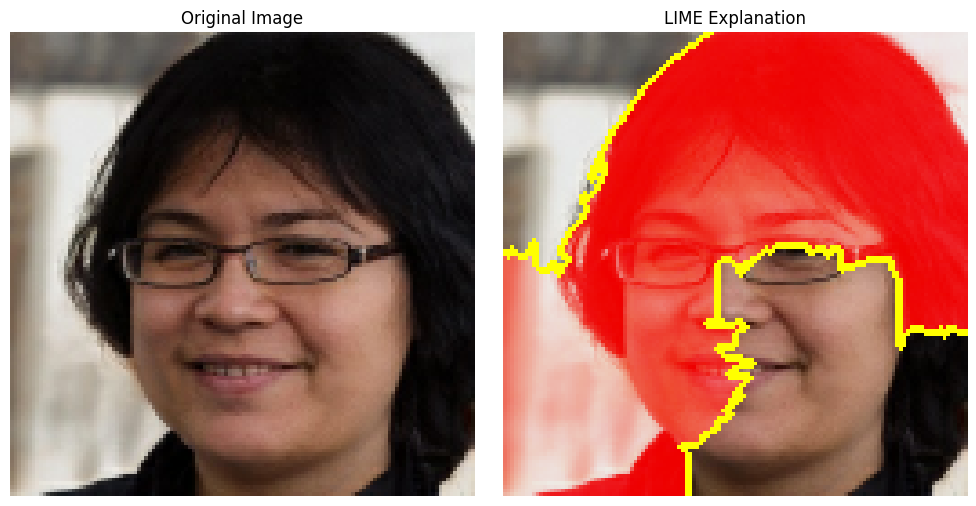

In [20]:
explainer = lime_image.LimeImageExplainer()

def explain_image(model, image, class_names):
    # Ensuring correct img dim
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Model Prediction
    predicted_class = model.predict(image)
    predicted_class_index = (predicted_class[0] > 0.6).astype(int)  # Binary threshold for sigmoid

    # Explanation using the model's predict method
    explanation = explainer.explain_instance(
        image=image[0].astype('double'),  
        classifier_fn=model.predict,
        top_labels=1, 
        hide_color=0,
        num_samples=1000
    )

    # Check labels in explanation
    print("Labels in explanation:", explanation.local_exp.keys())
    print("Predicted class index:", predicted_class_index[0])

    # Ensure the label exists in the explanation
    label = predicted_class_index[0]
    if label not in explanation.local_exp:
        print(f"Label {label} not in explanation. Using a fallback.")
        label = next(iter(explanation.local_exp.keys()))  # Fallback if label not found

    # Get the explanation for the predicted or fallback class
    temp, mask = explanation.get_image_and_mask(
        label=label,  
        positive_only=False,
        num_features=5,
        hide_rest=False
    )

    # Plot the original image and the LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(image[0])  
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    axes[1].imshow(mark_boundaries(temp, mask))  
    axes[1].set_title("LIME Explanation")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Use an image from the test dataset
for images, labels in test_full_ds.take(2):  # Iterate over the test dataset
    explain_image(model, images[0], class_names)
    break  # Use only one image from the dataset